In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

In [2]:
from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

## 3-equation New Keynesian Model

### The Economy
The representative household maximizes the following expected
discounted sum of utilities over possible paths of consumption and
labor:

\begin{align}
 & U_{t}=\mathrm{E}_{t}\sum_{k=0}^{\infty}\beta^{k}\left[\frac{C_{t+k}^{1-\sigma}}{1-\sigma}-\phi\frac{N_{t+k}^{1+\eta}}{1+\eta}\right]
\end{align}

The nominal period budget constraint is:

\begin{equation}
P_{t}C_{t}+B_{t}=W_{t}N_{t}+\left(1+i_{t-1}\right)B_{t-1}+P_{t}D_{t}
\end{equation}

The final output good is a CES aggregate of a continuum of intermediates:

\begin{equation}
Y_{t}=\left[\intop_{0}^{1}Y_{t}\left(i\right)^{\tfrac{\varepsilon-1}{\varepsilon}}di\right]^{\tfrac{\varepsilon}{\varepsilon-1}}
\end{equation}


Each monopolistic firm $i$ produces a differentiated variety and
hires a homogenous type of labor according to the linear production
function:

\begin{align}
Y_{t}\left(i\right)=A_{t}N_{t}\left(i\right)^{1-\alpha}
\end{align}

Following Calvo, we assume now that firms adjust their price infrequently and that
the opportunity to adjust follows an exogenous Poisson process. Each
period there is a constant probability ($1-\theta$) that the firm
will be able to adjust its price, independently of past history. The
expected time between price adjustments is therefore $\dfrac{1}{1-\theta}$.
If the law of large numbers holds this implies that the fraction of
retailers not setting prices at $t$ is $\theta$. The draw is independent
of history, so that we do not need to keep track of firms changing
prices over time.

The solutions to the above household and firm problems give the following three key equations of the New Keynesian model.

### New Keynesian Phillips Curve
\begin{align}
\pi_{t} & =\beta\mathrm{E}_{t}\pi_{t+1}+\kappa x_{t}
\end{align}

In the above equation:
\begin{align}
\text{Output gap:} \quad & x_{t}=y_{t}-y_{t}^{n}\\
\text{Output gap coefficient:} \quad & \kappa=\frac{\left(1-\theta\right)\left(1-\beta\theta\right)}{\theta}\left(\sigma+\eta\right)
\end{align}

The actual output and natural level of output are equal to:
\begin{align}
\text{Actual output:} \quad & y_{t} & =a_{t}+(1-\alpha)n_{t}\\
\text{Natural level of output} \quad & y_{t}^{n} & =\dfrac{1+\eta}{\sigma(1-\alpha)+\eta+\alpha}a_{t}
\end{align}

### New Keynesian IS
\begin{align}
x_{t} & =\mathrm{E}_{t}x_{t+1}-\frac{1}{\sigma}\left(i_{t}-\mathrm{E}_{t}\pi_{t+1}-r_{t}^{n}\right)
\end{align}

In the above equation:
\begin{align}
\text{Natural real interest rate:} \quad & r_{t}^{n} & =\rho+\sigma\left(\dfrac{1+\eta}{\sigma(1-\alpha)+\eta+\alpha}\mathrm{E}_{t}\triangle a_{t+1}\right)
\end{align}

The technology evolves according to:
\begin{align}
\text{TFP:} \quad & a_{t}=\rho_{a}a_{t-1}+\varepsilon_{a,t}
\end{align}

The devation of natural real interest rate from its steady-state is given by:
\begin{align}
\hat{r}_{t}^{n} & =-\sigma\left(\dfrac{1+\eta}{\sigma(1-\alpha)+\eta+\alpha}\right)(1-\rho_{a})a_{t}
\end{align}


### Monetary Policy Rule
\begin{align}
i_{t}=\phi_{\pi}\pi_{t}+\phi_{x}x_{t}+\nu_{t}
\end{align}

The monetary policy shock evolves according to:
\begin{align}
\text{Monetary Shock:} \quad & \nu_{t}=\rho_{\nu}\nu_{t-1}+\varepsilon_{R,t}
\end{align}

In the above equations, the parameters correspond to:

|Parameter | Justification	
|:---|:---|
$\alpha$ |	Share of capital in production (output)	
$\beta$	| Household discount factor		
$\sigma$ |	Risk aversion (Inverse of intertemporal elasticity of substitution)	
$\eta$	| Inverse Frisch-elasticity		
$\theta$	| quarterly probability of price rigidity		
$\kappa$	| Coefficient of output gap in NKPC		
$\phi_{\pi}$	| Response of monetary rule to inflation		
$\phi_{x}$	| Response of monetary rule to output gap	
$\rho_{a}$	| Coefficient in TFP AR(1) regression		
$\rho_{v}$	| Coefficient of monetary policy shock AR(1) regression		


In [3]:
from Dynare import *

In [4]:
var = 'Pi x i y r_r n p nu w y_n r_n a' #r_r is shock
varexo = 'eps_R' #Monetary Shock

param_values = {'alppha':0.25, sy.symbols('beta'):0.99, 'siggma':2, 'eta':3.77, 'rho_nu':0.5,
                'theta':0.75, 'kappa':0.1717, 'phi_pi':1.25, 'phi_x':0.125, 'rho_a':0.9}
# make phi_pi 0.75 to see the results which the model dont work
model = ('-Pi + betta*Pi(+1)+kappa*x', # inflation
         '-x + x(+1) -1/siggma*(i-Pi(+1)-r_n)', #output gap
         '-i + phi_pi*Pi+phi_x*x+nu',
         '-r_n + -siggma*(1+eta)/(siggma*(1-alppha)+eta+alppha)*(1-rho_a)*a',
         '-r_r + i-Pi(+1)',
         '-y_n + (1+eta)/(siggma*(1-alppha)+eta+alppha)*a',
         '-x + y-y_n',
         '-nu + rho_nu*nu(-1)+eps_R',
         '-a + rho_a*a(-1)',
         '-y + a+(1-alppha)*n',
         '-Pi + p-p(-1)',
         '-w+p+siggma*y+eta*n')

initval = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [5]:
rbc = Dynare(var, varexo, param_values, model, initval)

In [6]:
rbc.steady()


STEADY-STATE RESULTS

Pi 	0.0000
x 	0.0000
i 	0.0000
y 	0.0000
r_r 	0.0000
n 	0.0000
p 	0.0000
nu 	0.0000
w 	0.0000
y_n 	0.0000
r_n 	0.0000
a 	0.0000



POLICY AND TRANSITION FUNCTIONS

		Pi	x	i	y	r_r	n	p	nu	w	y_n	r_n	a
Constant	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
p(-1) 		0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	1.0000	0.0000	1.0000	0.0000	0.0000	0.0000
nu(-1) 		-0.1232	-0.3623	0.3007	-0.3623	0.3623	-0.4831	-0.1232	0.5000	-2.6691	0.0000	0.0000	0.0000
a(-1) 		-0.2796	-0.1775	-0.3717	0.6002	-0.1200	-0.3997	-0.2796	0.0000	-0.5860	0.7777	-0.1555	0.9000
eps_R     		-0.2464	-0.7246	0.6014	-0.7246	0.7246	-0.9662	-0.2464	1.0000	-5.3382	0.0000	0.0000	0.0000



	Impulse response functions to eps_R


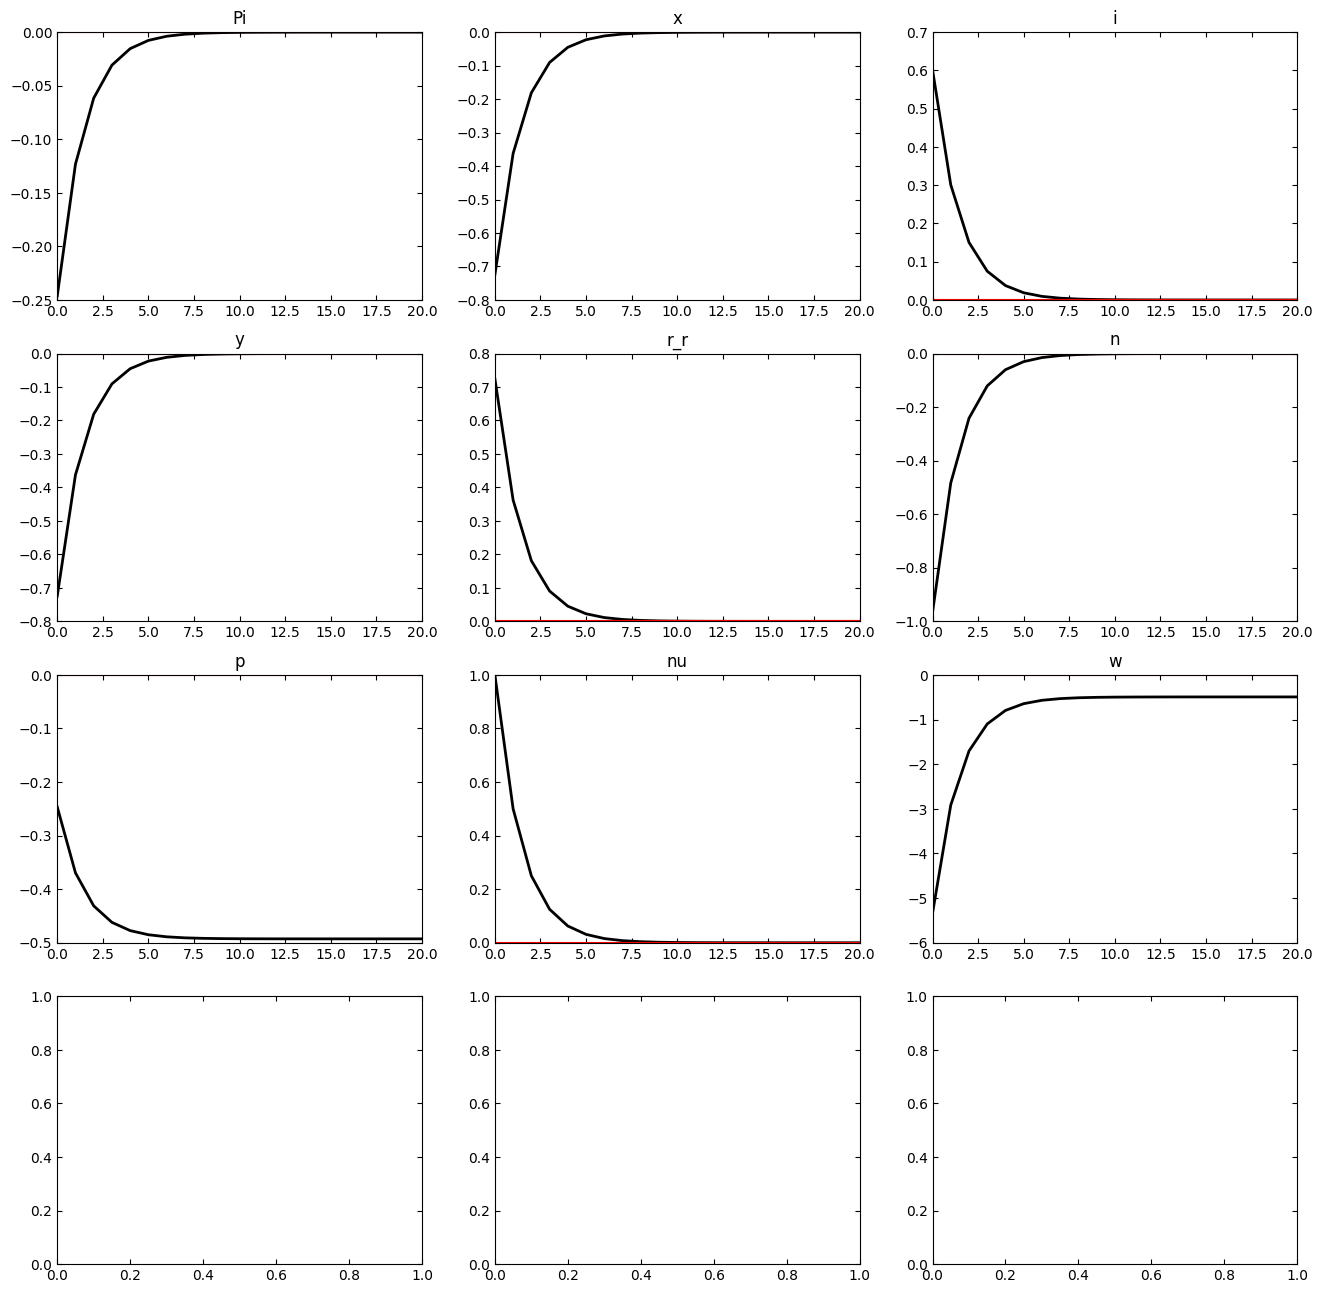

In [7]:
rbc.stoch_simul(irf=20)

## Empirical Macro

### VAR (Vector Autoregressions)

Consider a trivariate VAR with the following variables:

- Output ($y_{t}$) <br>
- Inflation ($\pi_{t}$) <br>
- Nominal Rate ($i_{t}$)

The reduced-form VAR with one lag can be shown as following:
\begin{align}
y_{t} & = a_{11}y_{t-1} + a_{12}\pi_{t-1} + a_{13}i_{t-1} + u_{y,t}\\
\pi_{t} & = a_{21}y_{t-1} + a_{32}\pi_{t-1} + a_{33}i_{t-1} + u_{\pi,t}\\
i_{t} & = a_{31}y_{t-1} + a_{32}\pi_{t-1} + a_{33}i_{t-1} + u_{i,t}
\end{align}

or in matrix form:
\begin{gather}
\begin{bmatrix} y_{t} \\ \pi_{t} \\ i_{t} \end{bmatrix}
=
\begin{bmatrix} a_{11} & a_{12} & a_{13}\\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{bmatrix}
\begin{bmatrix} y_{t-1} \\ \pi_{t-1} \\ i_{t-1} \end{bmatrix}
+
\begin{bmatrix} u_{y,t} \\ u_{\pi,t} \\ u_{i,t} \end{bmatrix}
\end{gather}

or in more compact form:
\begin{gather}
x_{t} = A x_{t-1} + u_{t}
\end{gather}

We can also write VAR with lag length p as following
\begin{gather}
x_{t} = A_{1} x_{t-1} + A_{2} x_{t-2} + ... + A_{p} x_{t-p} + u_{t}
\end{gather}

A VAR can help us answering the following questions: <br>
<ol>
<li>  What is the dynamic behavior of these variables? How do these variables interact? <br>
<li>  What is the most likely path of GDP in the next few quarters? <br>
<li>  What is the eect of a monetary policy shock on GDP? <br>
<li>  What has been the historical contribution of monetary policy shocks to GDP fluctuations?
</ol>

In [9]:
fred = DataReader(['GDPC1','GDPDEF','FEDFUNDS'], 'fred', start='1945', end='2030')

In [10]:
temp = fred.resample('QS').mean()

VAR3=pd.DataFrame()

VAR3['GDP']=100*np.log(temp['GDPC1']).diff(4) # years of growth gdp
VAR3['INFL'] = 100*np.log(temp['GDPDEF']).diff(4)
VAR3['FEDFUNDS'] = temp['FEDFUNDS']
VAR3 = VAR3.dropna()

VAR3.columns = ['Y','P','R']
VAR3.head()


,Y,P,R
DATE,,,
1954-07-01,-0.772738,0.723517,1.030000
1954-10-01,2.690571,0.811224,0.986667
1955-01-01,5.985945,0.958714,1.343333
1955-04-01,7.491120,1.284171,1.500000
1955-07-01,7.709530,1.850267,1.940000


In [11]:
VAR3.tail()

,Y,P,R
DATE,,,
2021-07-01,4.836774,4.914483,0.09
2021-10-01,5.559647,5.937446,0.08
2022-01-01,3.617453,6.705967,0.12
2022-04-01,1.780104,7.343115,0.77
2022-07-01,1.923520,6.904076,2.19


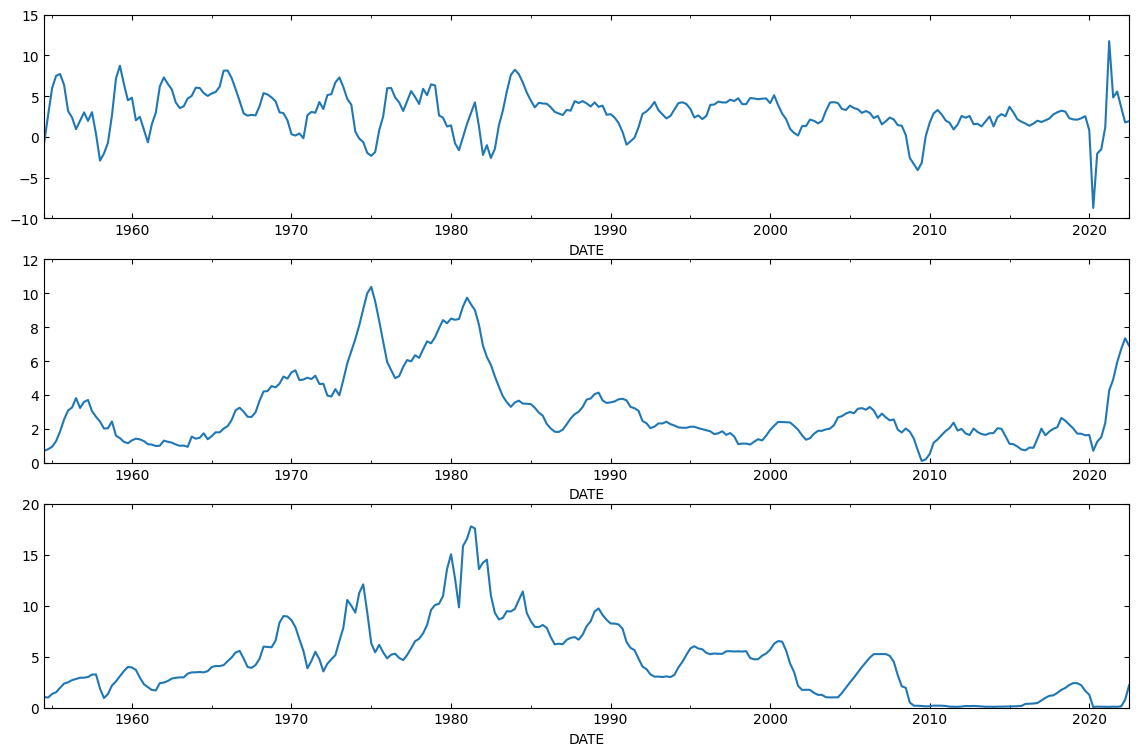

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9))

VAR3['Y'].to_period('D').plot(ax=ax1)
VAR3['P'].to_period('D').plot(ax=ax2)
VAR3['R'].to_period('D').plot(ax=ax3)

plt.show()

In [13]:
model = sm.tsa.VAR(VAR3[['Y','P','R']])
print(model.select_order(6))
model.select_order(6).summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 5, FPE -> 6, HQIC ->  5>


,AIC,BIC,FPE,HQIC
0,5.183,5.223,178.2,5.199
1,-1.546,-1.385,0.2132,-1.481
2,-1.901,-1.619,0.1495,-1.787
3,-1.983,-1.579,0.1377,-1.821
4,-2.021,-1.497,0.1326,-1.810
5,-2.287,-1.642*,0.1016,-2.028*
6,-2.327*,-1.561,0.09769*,-2.019


In [15]:
results = model.fit(6)

### Structural VAR and Identification of Shocks
What is the eect of a monetary policy or technology shock on GDP? The reduced form residuals cannot answer this question.

Assume dynamics of variables can be represented through VAR with one lag-length. The structural representation (the ‘true’ (and unobserved) model of the economy) is given by:
\begin{gather}
x_{t} = A x_{t-1} + B\epsilon_{t}
\end{gather}

or 

\begin{gather}
\begin{bmatrix} y_{t} \\ \pi_{t} \\ i_{t} \end{bmatrix}
=
A \begin{bmatrix} y_{t-1} \\ \pi_{t-1} \\ i_{t-1} \end{bmatrix}
+
\begin{bmatrix} b_{11} & b_{12} & b_{13}\\ b_{21} & b_{22} & b_{23} \\ b_{31} & b_{32} & b_{33} \end{bmatrix}
\begin{bmatrix} \epsilon_{y,t} \\ \epsilon_{\pi,t} \\ \epsilon_{i,t} \end{bmatrix}
\end{gather}

It is obvious that the reduced form innovations are a linear combination of the structural
shocks:
\begin{align}
u_{y,t} & = b_{11}\epsilon_{y,t} + b_{12}\epsilon_{\pi,t} + b_{13}\epsilon_{i,t}\\
u_{\pi,t} & = b_{21}\epsilon_{y,t} + b_{32}\epsilon_{\pi,t} + b_{33}\epsilon_{i,t}\\
u_{i,t} & = b_{31}\epsilon_{y,t} + b_{32}\epsilon_{\pi,t} + b_{33}\epsilon_{i,t}
\end{align}

For example, how to know whether increase in $u_{\pi,t}$ is due shock to output, inflation, or monetary policy? This is the very nature of the identification problem!

One way to solve identification problem is imposing contemporaneous relationship among variables. Assume that the shock to inflation or monetary policy affects the output one period later and monetary policy shock affects inflation one period later. In that case:
\begin{align}
u_{y,t} & = b_{11}\epsilon_{y,t} + 0\epsilon_{\pi,t} + 0\epsilon_{i,t}\\
u_{\pi,t} & = b_{21}\epsilon_{y,t} + b_{32}\epsilon_{\pi,t} + 0\epsilon_{i,t}\\
u_{i,t} & = b_{31}\epsilon_{y,t} + b_{32}\epsilon_{\pi,t} + b_{33}\epsilon_{i,t}
\end{align}

So we can identify the coefficients through variance-covariance matrices. This is also called orthogonal identification or recursive identification.

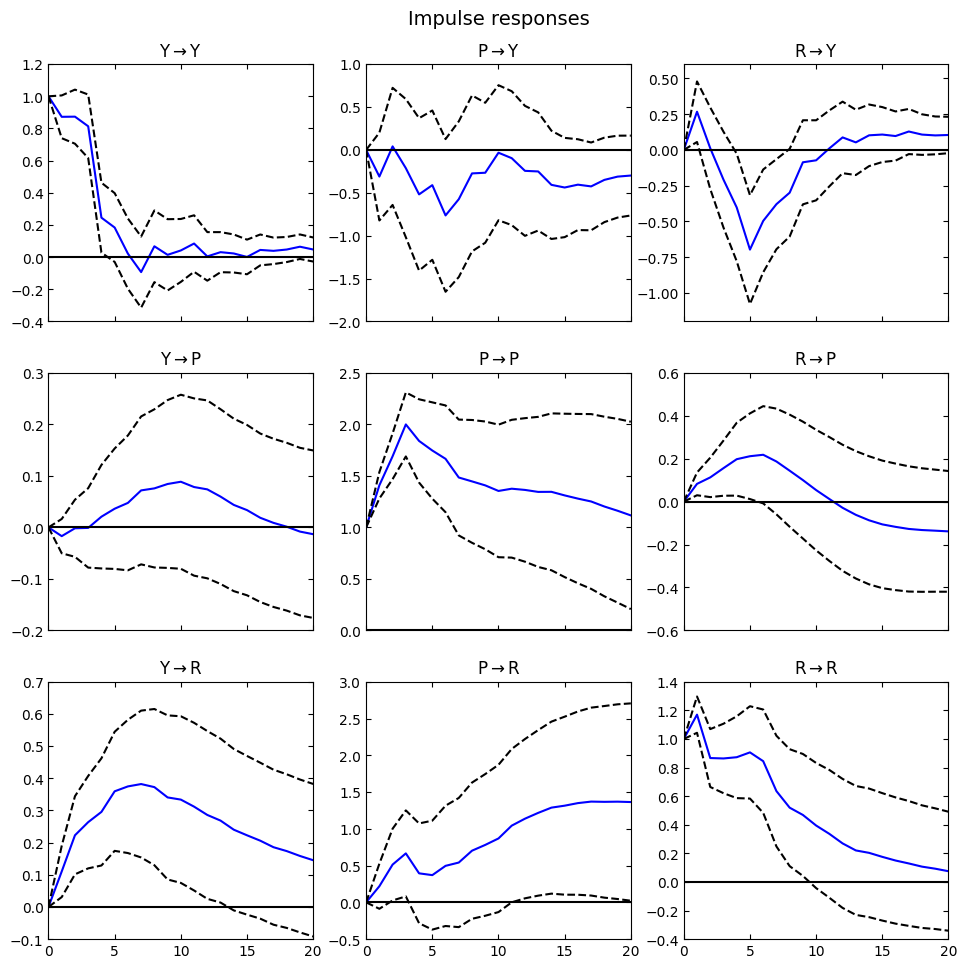

In [14]:
results.irf(20).plot()
plt.show()

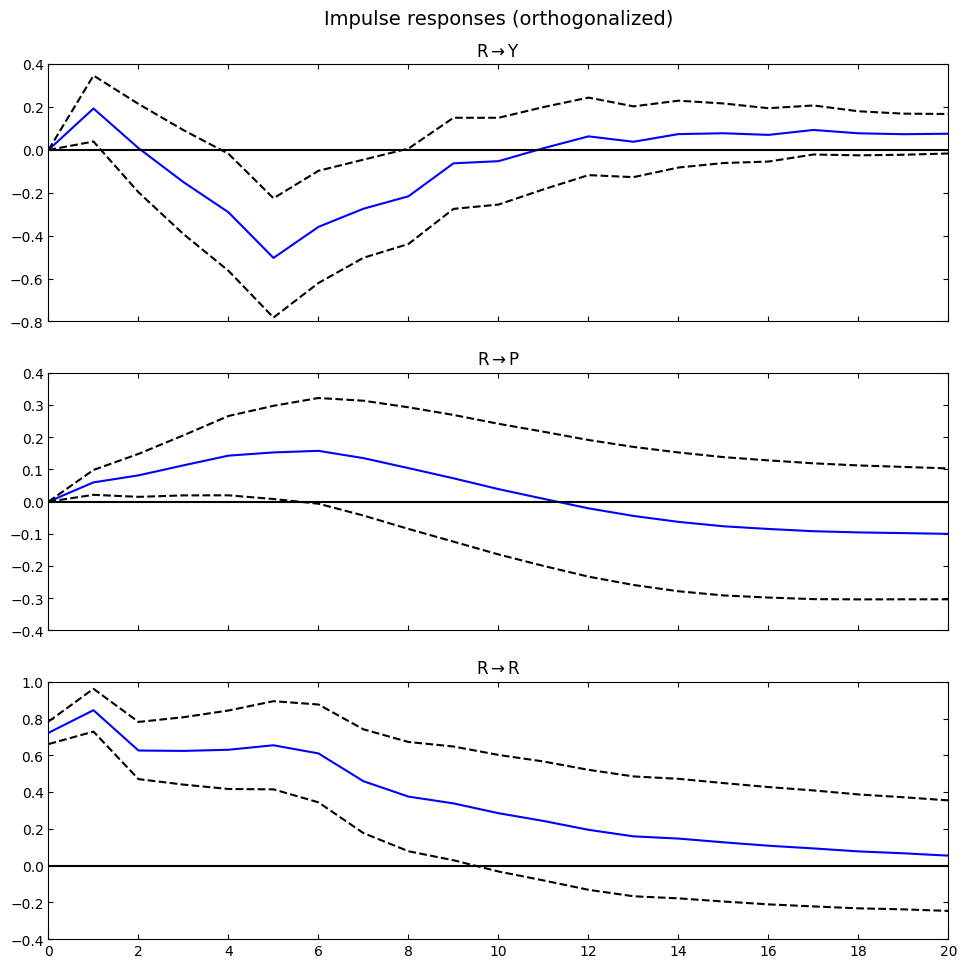

In [15]:
results.irf(20).plot(orth=True, impulse='R', signif=0.05)
plt.xticks(np.arange(0, 22, 2))
plt.show()

### Forecast with VAR

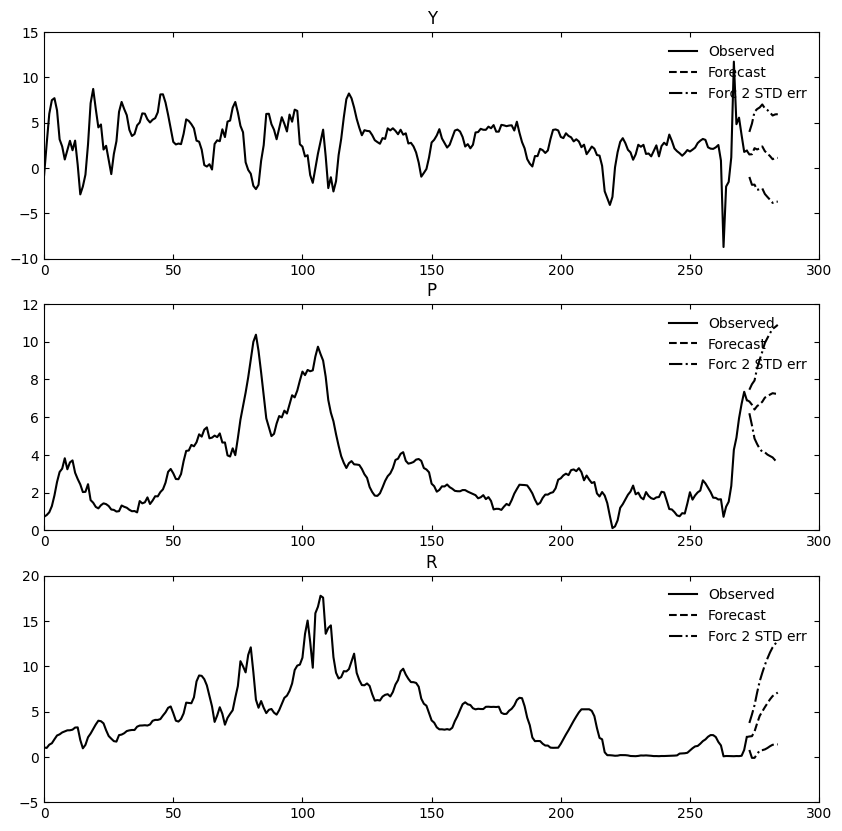

In [16]:
results.plot_forecast(12)
plt.show()

### Forecast Error Variance Decomposition

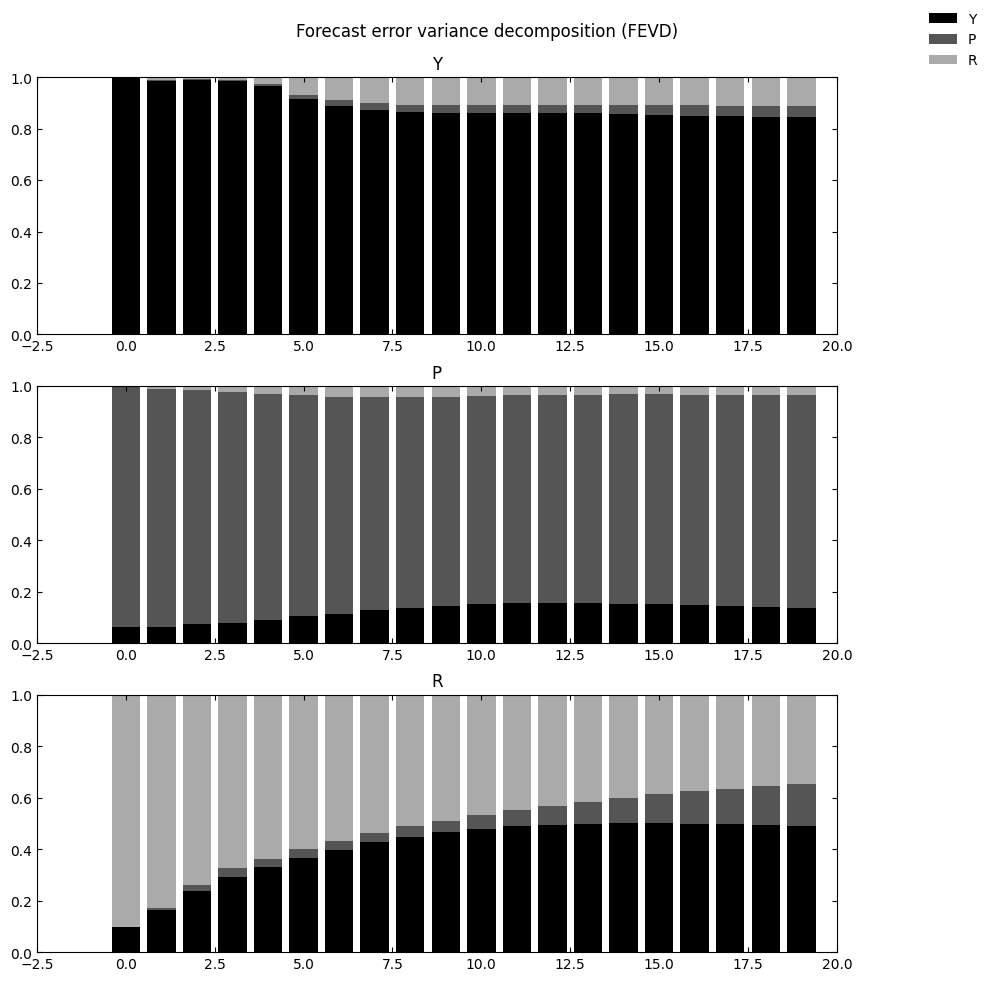

In [17]:
results.fevd(20).plot()
plt.show()

### VAR with GDP and Oil Prices

In [18]:
fred_new = DataReader(['GDPC1','GDPDEF','WTISPLC','FEDFUNDS'], 'fred', start='1945', end='2020')

temp_new = fred_new.resample('QS').mean()

In [19]:
VAR_new=pd.DataFrame()

VAR_new['GDP'] = np.log(temp_new['GDPC1'])
VAR_new['INFL'] = 100*np.log(temp_new['GDPDEF']).diff(4)
VAR_new['OIL'] = np.log(100*temp_new['WTISPLC']/temp_new['GDPDEF'])
VAR_new['FEDFUNDS'] = temp_new['FEDFUNDS']

VAR_new = VAR_new.dropna()

VAR_new.columns = ['Y','P','OP','R']
VAR_new.head()

,Y,P,OP,R
DATE,,,,
1954-07-01,7.895225,0.723517,2.963286,1.030000
1954-10-01,7.914603,0.811224,2.960543,0.986667
1955-01-01,7.942765,0.958714,2.955898,1.343333
1955-04-01,7.958906,1.284171,2.951749,1.500000
1955-07-01,7.972320,1.850267,2.944783,1.940000


In [20]:
model_new = sm.tsa.VAR(VAR_new[['Y','OP','P','R']])
print(model_new.select_order(6))
model_new.select_order(6).summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 2, FPE -> 6, HQIC ->  3>


,AIC,BIC,FPE,HQIC
0,0.07899,0.1342,1.082,0.1012
1,-16.24,-15.96,8.852e-08,-16.13
2,-16.65,-16.16*,5.857e-08,-16.45
3,-16.77,-16.05,5.231e-08,-16.48*
4,-16.78,-15.84,5.184e-08,-16.40
5,-16.83,-15.67,4.920e-08,-16.36
6,-16.92*,-15.54,4.505e-08*,-16.36


In [21]:
results_new = model_new.fit(6)

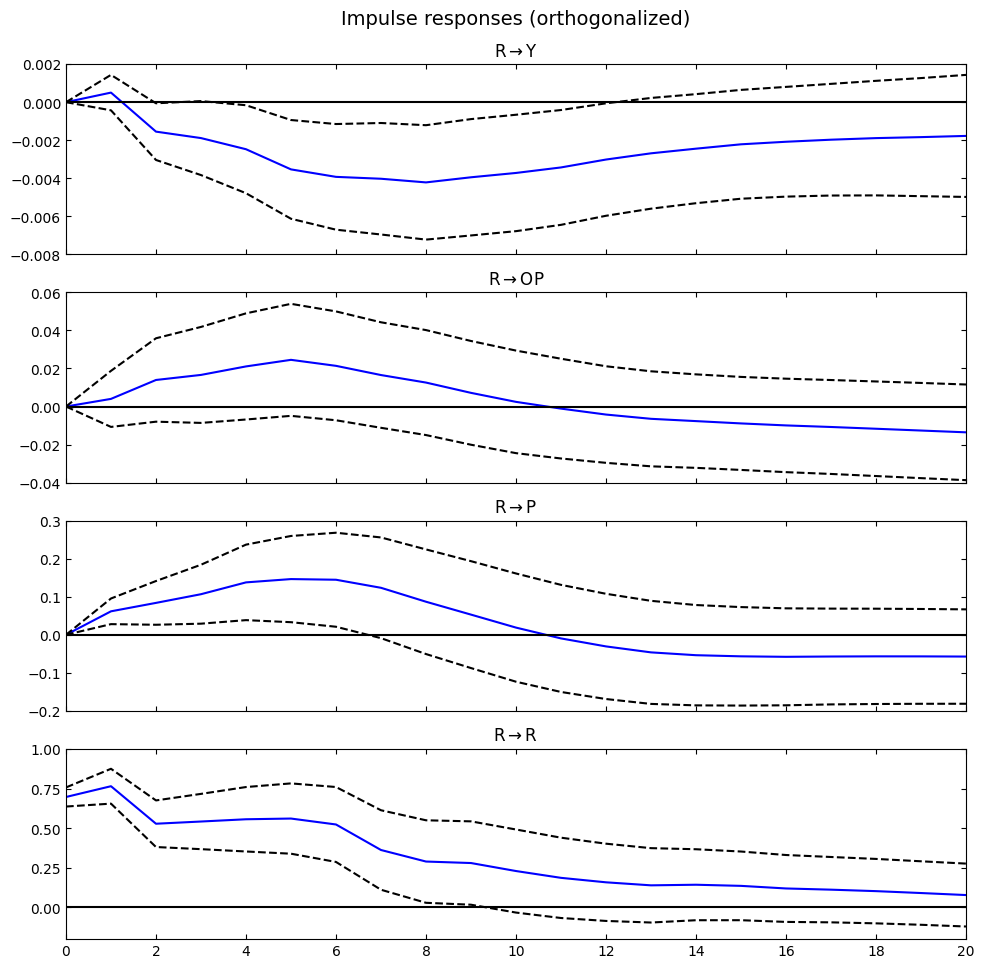

In [22]:
results_new.irf(20).plot(orth=True, impulse='R', signif=0.05)
plt.xticks(np.arange(0, 22, 2))
plt.show()

### VAR with Output Gap

In [23]:
fred_new2 = DataReader(['GDPPOT','GDPC1','GDPDEF','FEDFUNDS','M2SL'], 'fred', start='1950', end='2019')

temp_new2 = fred_new2.resample('QS').mean()


In [24]:
VAR_new2=pd.DataFrame()

VAR_new2['Y_GAP'] = 100*(np.log(temp_new2['GDPC1'])-np.log(temp_new2['GDPPOT']))
VAR_new2['GDP'] = 100*np.log(temp_new2['GDPC1']).diff(4)
VAR_new2['INFL']=100*np.log(temp_new2['GDPDEF']).diff(4)
VAR_new2['FEDFUNDS'] = temp_new2['FEDFUNDS']
VAR_new2['M2SL']=100*np.log(temp_new2['M2SL']).diff(4)

VAR_new2 = VAR_new2.dropna()
VAR_new2.columns = ['YG','Y','P','R','M']

VAR_new2.tail()

,YG,Y,P,R,M
DATE,,,,,
2018-01-01,-0.882434,3.017515,2.109545,1.446667,4.130731
2018-04-01,-0.652970,3.209910,2.653295,1.736667,3.760413
2018-07-01,-0.407469,3.105267,2.488471,1.923333,3.629573
2018-10-01,-0.700189,2.286249,2.255937,2.220000,3.311614
2019-01-01,-0.631667,2.137226,2.030113,2.400000,3.642377


In [25]:
model_new2 = sm.tsa.VAR(VAR_new2[['YG','P','R']])
print(model_new2.select_order(6))
model_new2.select_order(6).summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 2, FPE -> 6, HQIC ->  6>


,AIC,BIC,FPE,HQIC
0,5.050,5.095,156.1,5.068
1,-3.207,-3.028,0.04047,-3.135
2,-3.543,-3.230*,0.02893,-3.417
3,-3.641,-3.194,0.02624,-3.460
4,-3.616,-3.035,0.02690,-3.382
5,-3.699,-2.984,0.02476,-3.411
6,-3.826*,-2.976,0.02183*,-3.483*


In [26]:
results_new2 = model_new2.fit(2)

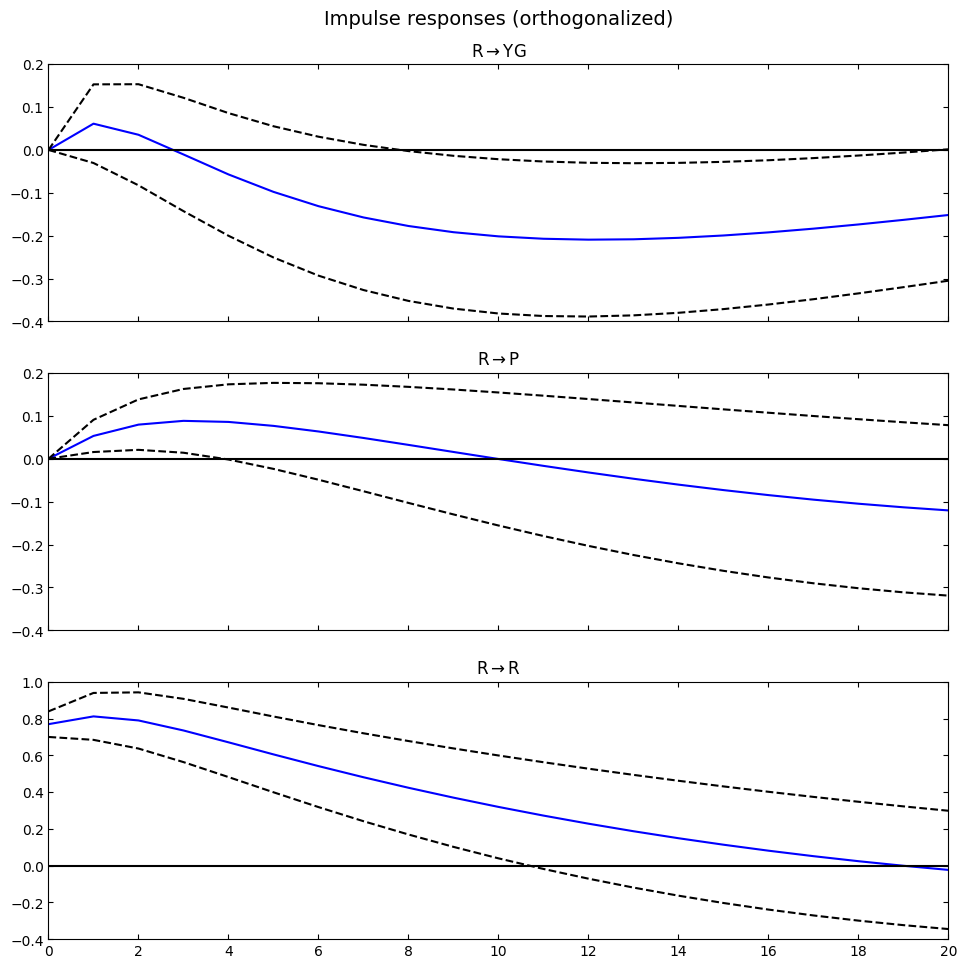

In [27]:
results_new2.irf(20).plot(orth=True, impulse='R', signif=0.05)
plt.xticks(np.arange(0, 22, 2))
plt.show()

# Homework
The other important shocks in the New Keynesian Model are demand and cost push-up shocks. We can incorporate them into the 3-eq New Keynesian model in following way.

The New Keynesian IS (NKIS) with demand shock where demand shock follows AR(1) process is given by

\begin{align}
x_{t} & =\mathrm{E}_{t}x_{t+1}-\frac{1}{\sigma}\left(i_{t}-\mathrm{E}_{t}\pi_{t+1}-r_{t}^{n}\right)+u_{t}\\
u_{t} & = \rho_{u}u_{t-1}+\epsilon_{u,t}
\end{align}

The New Keynesian Phillips Curve (NKPC) with cost push-up shock where cost push-up shock follows AR(1) process is given by

\begin{align}
\pi_{t} & =\beta\mathrm{E}_{t}\pi_{t+1}+\kappa x_{t}+e{t}\\
e_{t} & = \rho_{e}e_{t-1}+\epsilon_{e,t}
\end{align}


**Task 1**: Insert the **demand shock** given in the above **New Keynesian IS equation** into the New Keynesian Model. Compute impulse response functions (IRFS) of the variables following a **demand shock**. Briefly comment on the responses of inflation, output gap, and nominal interest rate. 

In [ ]:
var = 'Pi x i y r_r n p u w y_n r_n a'
varexo = 'eps_u'

param_values = {'alppha':0.25, sy.symbols('beta'):0.99, 'siggma':2, 'eta':3.77, 'rho_u':0.75,
                'theta':0.75, 'kappa':0.1717, 'phi_pi':1.25, 'phi_x':0.125, 'rho_a':0.9}

model = ('-Pi + betta*Pi(+1)+kappa*x',
#         'Here goes the New Keynesian IS curve with demand shock',
         '-i + phi_pi*Pi+phi_x*x',
         '-r_n + -siggma*(1+eta)/(siggma*(1-alppha)+eta+alppha)*(1-rho_a)*a',
         '-r_r + i-Pi(+1)',
         '-y_n + (1+eta)/(siggma*(1-alppha)+eta+alppha)*a',
         '-x + y-y_n',
#         'Here goes the AR(1) demand shock',
         '-a + rho_a*a(-1)',
         '-y + a+(1-alppha)*n',
         '-Pi + p-p(-1)',
         '-w+p+siggma*y+eta*n')

initval = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

**Task 2**: Insert the **cost push-up shock** given in the above **NKPC equation** into the New Keynesian Model. Compute impulse response functions (IRFS) of the variables following a **cost push-up shock**. Briefly comment on the responses of inflation, output gap, and nominal interest rate. 

In [ ]:
var = 'Pi x i y r_r n p e w y_n r_n a'
varexo = 'eps_e'

param_values = {'alppha':0.25, sy.symbols('beta'):0.99, 'siggma':2, 'eta':3.77, 'rho_e':0.75,
                'theta':0.75, 'kappa':0.1717, 'phi_pi':1.25, 'phi_x':0.125, 'rho_a':0.9}

model = (#         'Here goes the NKPC with cost push-up shock',
         '-x +x(+1) -1/siggma*(i-Pi(+1)-r_n)',
         '-i + phi_pi*Pi+phi_x*x',
         '-r_n + -siggma*(1+eta)/(siggma*(1-alppha)+eta+alppha)*(1-rho_a)*a',
         '-r_r + i-Pi(+1)',
         '-y_n + (1+eta)/(siggma*(1-alppha)+eta+alppha)*a',
         '-x + y-y_n',
#         'Here goes the AR(1) cost push-up shock',
         '-a + rho_a*a(-1)',
         '-y + a+(1-alppha)*n',
         '-Pi + p-p(-1)',
         '-w+p+siggma*y+eta*n')

initval = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

# Unemployment and Labor Markets over the Business Cycle

We will take a look at the data on unemployment and functioning of labor markets in the United States

Below we are downloading two datasets. 

The first dataset, `fred`, contains monthly data on: 

- whether in a given month the US economy was in a recession state (`1`) or not (`0`) - `USREC`
- number of people in labor force in thousands - `CLF16OV`
- number of unemployed people in thousands - `UNEMPLOY`
- unemployment rate in percent - `UNRATE`
- number of job openings (vacancies) in thousands - `JTSJOL`
- job vacancy rate - `JTSJOR`

The second dataset, `hours`, contains quarterly data on:

- real GDP in billions of 2009 dollars - `GDPC1`
- total hours worked in the nonfarm business sector (index) - `HOANBS`
- average hours worked per employee in the nonfarm business sector (index) - `PRS85006023`
- number of employees in the nonfarm business sector (index) - `PRS85006013`

In [ ]:
start = '1945-01'
end   = '2021-06'

In [ ]:
# Get FRED data
fred = DataReader(['USREC', 'CLF16OV', 'UNEMPLOY', 'UNRATE', 'JTSJOL', 'JTSJOR'], 
                   'fred', start=start, end=end)

hours = DataReader(['GDPC1', 'HOANBS', 'PRS85006023', 'PRS85006013'], 
                    'fred', start=start, end=end)

Separate trend and cyclical components of GDP, hours and employment

In [ ]:
hp_cycle = pd.DataFrame()
hp_trend = pd.DataFrame()

cf_cycle = pd.DataFrame()
cf_trend = pd.DataFrame()

for col in hours.columns:
    hp_cycle[col], hp_trend[col] = sm.tsa.filters.hpfilter(100*np.log(hours[col]).dropna(), lamb=1600)
    cf_cycle[col], cf_trend[col] = sm.tsa.filters.cffilter(100*np.log(hours[col]).dropna(), low=6, high=32)

Compare cyclical components of total hours worked vs its components: hours per employee and number of employees

In [ ]:
hp_cycle.columns = ['Output','Total Hours','Hours per Employee','Employment']
cf_cycle.columns = ['Output','Total Hours','Hours per Employee','Employment']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

cf_cycle[['Total Hours','Employment']].to_period('D').plot(ax=ax1, style=['k-','r-'], lw=2)

ylim = ax1.get_ylim()

ax1.hlines(0, cf_cycle.index[0], cf_cycle.index[-1], linewidth=0.5)
ax1.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax1.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

cf_cycle[['Total Hours','Hours per Employee']].to_period('D').plot(ax=ax2, style=['k-','r-'], lw=2)

ylim = ax2.get_ylim()

ax2.hlines(0, cf_cycle.index[0], cf_cycle.index[-1], linewidth=0.5)
ax2.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax2.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

# plt.savefig('Hours_CF.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Calculate the variance-covariance matrix of total hours worked and its components

In [ ]:
hp_cycle[['Total Hours','Employment','Hours per Employee']].cov()

## Constructing the vacancy rate time series

The statistics on job openings (vacancies) from the `JOLTS` program are available only starting from December 2000. However, there are data on `Help Wanted Index`, which were gathered by private companies. Thanks to the work of Regis Barnichon, we can use them.

In [ ]:
dta = fred.copy()
dta.tail()

In [ ]:
dta[['JTSJOR','UNRATE']]['2000-12':].plot(lw=2)
plt.legend(frameon=False)
plt.show()

Read in Regis Barnichon's Composite Help Wanted Index and join the two datasets

In [ ]:
hwi = pd.read_csv('data/HWI_index_old.txt', delimiter='\t', skiprows=5)

# Manage dates
dates = []
for date in hwi['Date ']:
    dates.append(date[-2:]+'-01-'+date[0:4])

hwi.index = pd.to_datetime(dates)
hwi.index.rename('DATE', inplace=True)

# Cleanup
hwi = hwi.drop('Date ', 1)
hwi.columns = ['HWI']
hwi.tail()

In [ ]:
# Join datasets
df = dta.join(hwi)
df.tail()

Adjust the index to observed levels and splice the data from two sources

In [ ]:
df['Vacancies'] = df['JTSJOL']['2014-01-01'] * df['HWI'] / df['HWI']['2014-01-01']
df['Vacancies']['2005-01-01':] = df['JTSJOL']['2005-01-01':]

df[['Vacancies','JTSJOL']].plot(lw=2)
plt.legend(frameon=False)
plt.show()

Construct time series for unemployment and vacancy rates

In [ ]:
df['Unemployment rate'] = 100 * df['UNEMPLOY'] / df['CLF16OV']
df['Vacancy rate'] = 100 * df['Vacancies'] / df['CLF16OV']

In [ ]:
fig, ax = plt.subplots()

df['Vacancy rate'].to_period('D').plot(ax=ax, style='k', lw=2)
df['Unemployment rate'].to_period('D').plot(ax=ax, style='r', lw=2)

ylim = ax.get_ylim()

ax.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax.legend(loc='upper left')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

plt.title('US vacancy and unemployment rates (%)')
# plt.savefig('VU.pdf')
plt.show()

## Behavior of unemployment and vacancy rates in the United States

Below I plot the scatterplot of unemployment and vacancy rates, with colors reflecting different decades. 

The resulting negative relationship is known as the Beveridge curve

In [ ]:
dfq = df.resample('QS').mean()

plt.plot(dfq['Unemployment rate']['1950-01-01':'1959-12-01'], 
         dfq['Vacancy rate']['1950-01-01':'1959-12-01'], 'o-', label='1950s')
plt.plot(dfq['Unemployment rate']['1960-01-01':'1969-12-01'], 
         dfq['Vacancy rate']['1960-01-01':'1969-12-01'], 'o-', label='1960s')
plt.plot(dfq['Unemployment rate']['1970-01-01':'1979-12-01'], 
         dfq['Vacancy rate']['1970-01-01':'1979-12-01'], 'o-', label='1970s')
plt.plot(dfq['Unemployment rate']['1980-01-01':'1989-12-01'], 
         dfq['Vacancy rate']['1980-01-01':'1989-12-01'], 'o-', label='1980s')
plt.plot(dfq['Unemployment rate']['1990-01-01':'1999-12-01'], 
         dfq['Vacancy rate']['1990-01-01':'1999-12-01'], 'o-', label='1990s')
plt.plot(dfq['Unemployment rate']['2000-01-01':'2009-12-01'], 
         dfq['Vacancy rate']['2000-01-01':'2009-12-01'], 'o-', label='2000s')
plt.plot(dfq['Unemployment rate']['2010-01-01':'2019-12-01'], 
         dfq['Vacancy rate']['2010-01-01':'2019-12-01'], 'ko-', label='2010s')

plt.legend(frameon=False)
plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')

plt.title('Shifts in the US Beveridge curve')
# plt.savefig('BC.pdf')
plt.show()

Separate trend from cycle to eliminate structural shifts to the Beveridge curve, note the adjustment of filtering options to monthly frequency

In [ ]:
hp_cycle_uv = pd.DataFrame()
hp_trend_uv = pd.DataFrame()

cf_cycle_uv = pd.DataFrame()
cf_trend_uv = pd.DataFrame()

for col in ['Vacancy rate','Unemployment rate']:
    hp_cycle_uv[col], hp_trend_uv[col] = sm.tsa.filters.hpfilter(100*np.log(df[col]).dropna(), lamb=1600*3**4)
    cf_cycle_uv[col], cf_trend_uv[col] = sm.tsa.filters.cffilter(100*np.log(df[col]).dropna(), low=1.5*12, high=8*12)

Plot cyclical components of unemployment and vacancy rates vs cyclical component of output

In [ ]:
fig, ax = plt.subplots()

cf_cycle_uv.resample('QS').mean().to_period('D').plot(ax=ax, style=['k','r'], lw=2)
cf_cycle['Output'].plot(ax=ax, style=['b'], lw=2)

ax.set_ylim(-60, 60)
ylim = ax.get_ylim()

ax.hlines(0, hours.index[0], hours.index[-1], linewidth=0.5)

ax.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

ax.set_xlim('1950-01', hours.index[-1])

l = ax.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

plt.title('Deviations from Christiano-Fitzgerald trend (%)')
# plt.savefig('VU_CF.pdf')
plt.show()

Run a (very simplified) linear regression on cyclical components of unemployment and vacancy rates, the slope is very close to -1

In [ ]:
x = hp_cycle_uv['Unemployment rate']
y = hp_cycle_uv['Vacancy rate']

slope, intercept = np.polyfit(x, y, 1)

print(slope)
print(intercept)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(x, y, alpha=0.25) #facecolor='none', edgecolor='C0'
plt.plot(x, intercept + slope*x, 'r-', lw=2)

plt.xlim(-45, 45)
plt.ylim(-45, 45)

plt.hlines(0, -45, 45, linewidth=0.5)
plt.vlines(0, -45, 45, linewidth=0.5)

plt.title('Deviations from Hodrick-Prescott trend (%)')
plt.xlabel('Unemployment rate')
plt.ylabel('Vacancy rate')

# plt.savefig('BC_HP.pdf')

plt.show()

Generate the 'estimated' Beveridge curve without structural shifts

In [ ]:
u = np.mean(dfq['Unemployment rate'])
v = np.mean(dfq['Vacancy rate'])

print(u, v)

scale = np.linspace(-40, 60, 101)

plt.plot(u*np.exp(scale/100), v*np.exp(slope*scale/100), 'r', lw=2)

plt.plot(u, v, 'ko')

plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

# plt.hlines(v, 2, u, linestyle='--', lw=1)
# plt.vlines(u, 1, v, linestyle='--', lw=1)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')
plt.title('US Beveridge curve without structural shifts')

# plt.savefig('BC_est.pdf')

plt.show()

In [ ]:
u = np.mean(dfq['Unemployment rate'])
v = np.mean(dfq['Vacancy rate'])

print(u, v)

scale = np.linspace(-40, 60, 101)

plt.plot(u*np.exp(scale/100), v*np.exp(slope*scale/100), 'r', lw=2)
plt.scatter(u*np.exp(x/100), v*np.exp(y/100), alpha=0.25) #, marker='.'

plt.plot(u, v, 'ko')

plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

plt.hlines(v, 2, 12, linewidth=0.5)
plt.vlines(u, 1, 5, linewidth=0.5)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')
plt.title('US Beveridge curve without structural shifts')

# plt.savefig('BC_est_2.pdf')

plt.show()